In [1]:
#importing necessary python packages
import pandas as pd
import numpy as np
import os

In [2]:
# Importing the dataset
dt = pd.read_excel('LUAD_clinical.xlsx',index_col=0)


In [3]:
dt.shape

(517, 347)

In [4]:
dt.head(2)

,Diagnosis Age,Birth from Initial Pathologic Diagnosis Date,Last Alive Less Initial Pathologic Diagnosis Date Calculated Day Value,Fraction Genome Altered,Year Cancer Initial Diagnosis,Longest Dimension,Number of Samples Per Patient,Sample type id,Shortest Dimension,Specimen Second Longest Dimension,...,Tissue Source Site_NJ,Tissue Source Site_O1,Tissue Source Site_S2,Person Neoplasm Status_TUMOR FREE,Person Neoplasm Status_WITH TUMOR,Vial number_A,Vial number_B,Patient's Vital Status_Alive,Patient's Vital Status_Dead,Overall Survival (Months)2
Sample ID,,,,,,,,,,,,,,,,,,,,,
TCGA-05-4244-01,70.0,-25752.0,0,0.456523,2009.0,1.1,1,1,0.3,0.9,...,0,0,0,1,0,1,0,1,0,0.00
TCGA-05-4249-01,67.0,-24532.0,0,0.222128,2007.0,1.4,1,1,0.4,0.8,...,0,0,0,1,0,1,0,1,0,50.03


In [6]:
del dt['Patient\'s Vital Status_Dead']
del dt['Patient\'s Vital Status_Alive']

In [7]:
dt.shape

(517, 345)

In [8]:
X = dt.iloc[:,0:344].values
y = dt.iloc[:, -1].values

In [9]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [10]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)
X_val = sc_X.fit_transform(X_val)

In [11]:
sc_y = StandardScaler()
y_train = np.squeeze(sc_y.fit_transform(y_train.reshape(-1, 1)))
y_val = np.squeeze(sc_y.transform(y_val.reshape(-1, 1)))
y_test = np.squeeze(sc_y.transform(y_test.reshape(-1, 1)))

In [12]:
# Fitting Simple Linear Regression to the Training set
from sklearn.linear_model import ElasticNet
regressor = ElasticNet()


regressor.fit(X_train, y_train)

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [13]:
#Predicting the Validation set results
y_predval = regressor.predict(X_val)

In [14]:
# Print result of MAE
from sklearn import metrics
print(metrics.mean_absolute_error(y_val, y_predval))

# Print result of MSE
print(metrics.mean_squared_error(y_val, y_predval))

# Print result of RMSE
print(np.sqrt(metrics.mean_squared_error(y_val, y_predval)))

# Explained variance score: 1 is perfect prediction (Accuracy Score)
print('Variance score: %.2f' % regressor.score(X_val, y_val))



0.6216751317321926
0.709901734284034
0.8425566653252671
Variance score: 0.00


R^2 = 0.0043


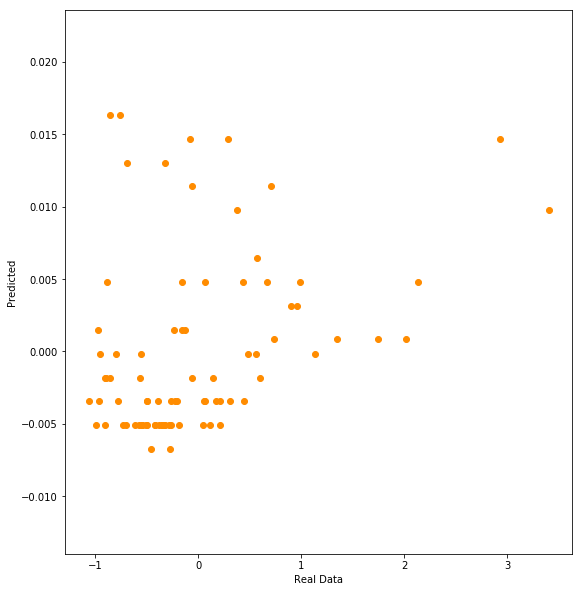

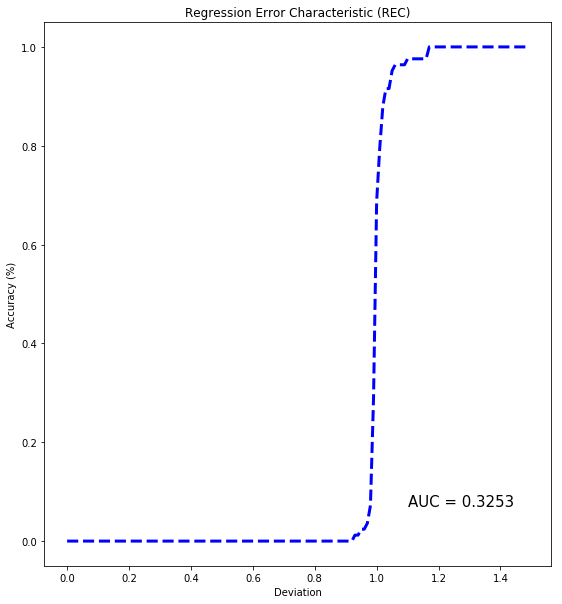

In [16]:
# Visualising the Random Forest Regression Results
# Loading Packages
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score
#from sklearn import linear_model
from sklearn import datasets
from scipy.integrate import simps

# Function for Regression Error Characteritic Curve

def REC(y_val , y_predval):
    
    # initilizing the lists
    Accuracy = []
    
    # initializing the values for Epsilon
    Begin_Range = 0
    End_Range = 1.5
    Interval_Size = 0.01
    
    # List of epsilons
    Epsilon = np.arange(Begin_Range , End_Range , Interval_Size)
    
    # Main Loops
    for i in range(len(Epsilon)):
        count = 0.0
        for j in range(len(y_val)):
            if np.linalg.norm(y_val[j] - y_predval[j]) / np.sqrt( np.linalg.norm(y_val[j]) **2 + np.linalg.norm(y_predval[j])**2 ) < Epsilon[i]:
                count = count + 1
        
        Accuracy.append(count/len(y_val))
    
    # Calculating Area Under Curve using Simpson's rule
    AUC = simps(Accuracy , Epsilon ) / End_Range
        
    # returning epsilon , accuracy , area under curve    
    return Epsilon , Accuracy , AUC

# finding the deviation and accuracy, and area under curve for plotting
Deviation, Accuracy, AUC = REC(y_val, y_predval)

# Calculating R^2 of the true and predicted values
RR = r2_score(y_val, y_predval)

# Plotting
plt.figure(figsize=(20 , 10))

plt.subplot(1, 2, 1)
plt.scatter(y_val, y_predval,color = "darkorange")
plt.xlabel("Real Data")
plt.ylabel("Predicted")
plt.figure(figsize=(20 , 10))
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=4)
print("R^2 = %0.4f" %RR)


plt.subplot(1, 2, 2)
plt.title("Regression Error Characteristic (REC)")
plt.plot(Deviation, Accuracy, "--b",lw =3)
plt.xlabel("Deviation")
plt.ylabel("Accuracy (%)")
plt.text(1.1, 0.07, "AUC = %0.4f" %AUC , fontsize=15)


plt.show()

In [17]:
# GRID SEARCH
from sklearn.model_selection import GridSearchCV

param_grid = { 'alpha':[0.15,0.1,0.3,0.5,0.7,0.9,1.0], 'l1_ratio':[0.1,0.2,0.3,0.5,0.7,0.9,1.0],
                  "max_iter": [100,500,1000]
                  }  


In [18]:
regressor = ElasticNet()
grid = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=10)
grid_search = grid.fit(X_train, y_train)

In [19]:
print(grid_search.best_score_, grid_search.best_params_)

0.3442651507320347 {'alpha': 0.15, 'l1_ratio': 0.2, 'max_iter': 100}


In [20]:
# Fitting Simple Linear Regression to the Training set
from sklearn.linear_model import ElasticNet
regressor = ElasticNet(alpha= 0.15, l1_ratio = 0.2, max_iter = 100)


regressor.fit(X_train, y_train)

ElasticNet(alpha=0.15, copy_X=True, fit_intercept=True, l1_ratio=0.2,
      max_iter=100, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [21]:
#Predicting the Validation set results
y_predval = regressor.predict(X_val)

In [22]:
# Print result of MAE
from sklearn import metrics
print(metrics.mean_absolute_error(y_val, y_predval))

# Print result of MSE
print(metrics.mean_squared_error(y_val, y_predval))

# Print result of RMSE
print(np.sqrt(metrics.mean_squared_error(y_val, y_predval)))

# Explained variance score: 1 is perfect prediction (Accuracy Score)
print('Variance score: %.2f' % regressor.score(X_val, y_val))

0.5301883566405359
0.5498963647462927
0.7415499745440577
Variance score: 0.23


R^2 = 0.2287


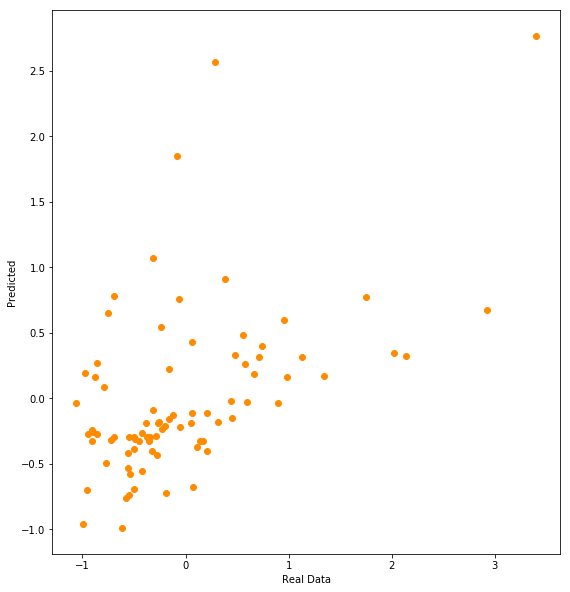

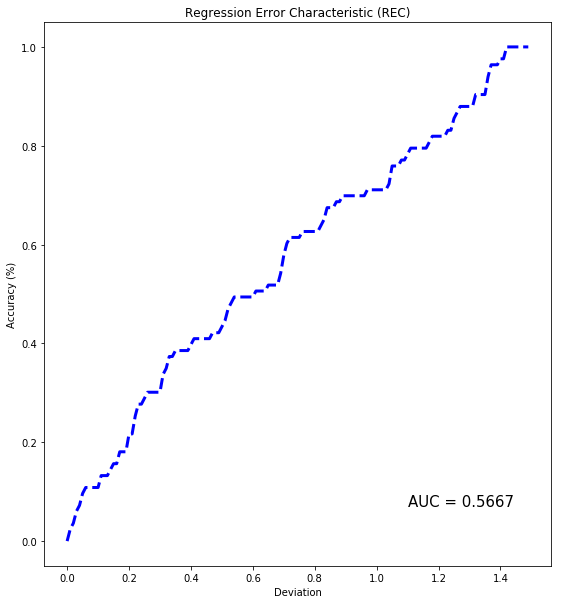

In [23]:
# Visualising the Random Forest Regression Results
# Loading Packages
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score
#from sklearn import linear_model
from sklearn import datasets
from scipy.integrate import simps

# Function for Regression Error Characteritic Curve

def REC(y_val , y_predval):
    
    # initilizing the lists
    Accuracy = []
    
    # initializing the values for Epsilon
    Begin_Range = 0
    End_Range = 1.5
    Interval_Size = 0.01
    
    # List of epsilons
    Epsilon = np.arange(Begin_Range , End_Range , Interval_Size)
    
    # Main Loops
    for i in range(len(Epsilon)):
        count = 0.0
        for j in range(len(y_val)):
            if np.linalg.norm(y_val[j] - y_predval[j]) / np.sqrt( np.linalg.norm(y_val[j]) **2 + np.linalg.norm(y_predval[j])**2 ) < Epsilon[i]:
                count = count + 1
        
        Accuracy.append(count/len(y_val))
    
    # Calculating Area Under Curve using Simpson's rule
    AUC = simps(Accuracy , Epsilon ) / End_Range
        
    # returning epsilon , accuracy , area under curve    
    return Epsilon , Accuracy , AUC

# finding the deviation and accuracy, and area under curve for plotting
Deviation, Accuracy, AUC = REC(y_val, y_predval)

# Calculating R^2 of the true and predicted values
RR = r2_score(y_val, y_predval)

# Plotting
plt.figure(figsize=(20 , 10))

plt.subplot(1, 2, 1)
plt.scatter(y_val, y_predval,color = "darkorange")
plt.xlabel("Real Data")
plt.ylabel("Predicted")
plt.figure(figsize=(20 , 10))
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=4)
print("R^2 = %0.4f" %RR)


plt.subplot(1, 2, 2)
plt.title("Regression Error Characteristic (REC)")
plt.plot(Deviation, Accuracy, "--b",lw =3)
plt.xlabel("Deviation")
plt.ylabel("Accuracy (%)")
plt.text(1.1, 0.07, "AUC = %0.4f" %AUC , fontsize=15)


plt.show()